In [1]:
########################################################### IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../src')
from data_preparation import get_birth_data, separate_data, separate_data_with_monday_flag

tf.keras.backend.set_floatx("float64")


In [3]:
tf.keras.backend.set_floatx("float64")

data = get_birth_data()
x, y, m = separate_data_with_monday_flag(data, normalised=True)
# x_w, y_w = separate_data(data, normalised=True, weekdays=True)

x = x.numpy()
y = y.numpy()
m = m.numpy()

def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs

pos, labels = get_xticks(data)

In [6]:
def plot_distribution(X, Y, loc, scale, pos, labels):
    plt.figure(figsize=(15, 5))
    x = X.squeeze()

    lb = (loc - 1.96 * scale).squeeze()
    ub = (loc + 1.96 * scale).squeeze()

    plt.fill_between(x, lb, ub, color="C0", alpha=0.4)
    #plt.plot(x, lb, color="C0")
    #plt.plot(x, ub, color="C0")
    plt.plot(X, Y, '.', color="black", alpha=0.5, markersize=3)
    plt.plot(X, loc, color="C0")

    plt.title('EXP(GP)  --- Amazing!!!')
    plt.xticks(pos, labels)
    plt.xlabel('Date')
    plt.ylabel('Births')
    
    plt.show()
    plt.close()

In [25]:
from typing import Any, Optional, Type

import tensorflow as tf
import tensorflow_probability as tfp

from gpflow.utilities import positive
from gpflow.base import TensorType
from gpflow.likelihoods.multilatent import MultiLatentTFPConditional

class CustomTFPConditional(MultiLatentTFPConditional):
    """
    Heteroskedastic Likelihood where the conditional distribution
    is given by a TensorFlow Probability Distribution.
    The `loc` and `scale` of the distribution are given by a
    two-dimensional multi-output GP.
    """

    def __init__(
        self,
        distribution_class: Type[tfp.distributions.Distribution] = tfp.distributions.Normal,
        loc_transform: Optional[tfp.bijectors.Bijector] = None,
        monday_flag = None,
        **kwargs: Any,
    ) -> None:
        """
        :param distribution_class: distribution class parameterized by `loc` and `scale`
            as first and second argument, respectively.
        :param scale_transform: callable/bijector applied to the latent
            function modelling the scale to ensure its positivity.
            Typically, `tf.exp` or `tf.softplus`, but can be any function f: R -> R^+. Defaults to exp if not explicitly specified.
        """

        if loc_transform is None:
            loc_transform = tfp.bijectors.Identity()
        self.loc_transform = loc_transform
        self.monday_flag = monday_flag

        def conditional_distribution(Fs: TensorType) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
        
            scale_transform = positive(base="exp")
            scale = scale_transform(Fs[..., 1:])

            dist = tfd.Normal(loc=0., scale=1.)
            beta = dist.sample([Fs.shape[0]])    # (400, 7305, 2) = Fs.shape
            beta = tf.cast(x, dtype=tf.float64)
            
            loc = Fs[..., :1] + beta * self.loc_transform(Fs[..., :1])
            return distribution_class(loc, scale)

        super().__init__(
            latent_dim=2,
            conditional_distribution=conditional_distribution,
            **kwargs,
        )

In [26]:
likelihood = CustomTFPConditional(
    distribution_class = tfp.distributions.Normal,  # Gaussian Likelihood
    loc_transform = tfp.bijectors.Exp(),  # Exponential Transform
)

print(f"Likelihood's expected latent_dim: {likelihood.latent_dim}")

#### jitter
kernel = gpflow.kernels.SeparateIndependent(
    [
        gpflow.kernels.RBF(),  #gpflow.kernels.Periodic(gpflow.kernels.RBF()) gpflow.kernels.Matern52() + 
        gpflow.kernels.RBF(),  
    ]
)


M = 2000  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(x.min(), x.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpflow.inducing_variables.InducingPoints(Z),  
        gpflow.inducing_variables.InducingPoints(Z),  
    ]
)

model = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
)

# model = gpflow.models.VGP(
#     data=(x.numpy(),y.numpy()),
#     kernel=kernel,
#     likelihood=likelihood,
#     num_latent_gps=likelihood.latent_dim,
# )

model

Likelihood's expected latent_dim: 2


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(2000, 1)",float64,[[1.00000000e+00...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(2000, 1)",float64,[[1.00000000e+00...
SVGP.q_mu,Parameter,Identity,,True,"(2000, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 2000, 2000)",float64,"[[[1., 0., 0...."


Epoch  1
Tensor("add_16:0", shape=(400, 7305, 2), dtype=float64) (400, 7305, 2)
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch 5 - Loss:  172583500079.2316
tf.Tensor(
[[[-2.4313293  -0.43616918]
  [-6.42965022 -5.14319379]
  [-7.5267743  -6.80432869]
  ...
  [-7.40700057 -6.70689008]
  [-6.14317562 -5.19132434]
  [-1.0373788   0.32050155]]

 [[-2.22532166 -0.43616918]
  [-5.59470686 -5.14319379]
  [-6.48702263 -6.80432869]
  ...
  [-6.3803242  -6.70689008]
  [-5.31867658 -5.19132434]
  [-0.9852331   0.32050155]]

 [[-2.05213655 -0.43616918]
  [-4.89279229 -5.14319379]
  [-5.61293118 -6.80432869]
  ...
  [-5.5172248  -6.70689008]
  [-4.62554226 -5.19132434]
  [-0.94139561  0.32050155]]

 ...

 [[ 0.02148712  2.14404253]
  [ 3.51154832  6.3102139 ]
  [ 4.85296106  7.48791615]
  ...
  [ 4.81705455  7.40702696]
  [ 3.67366838  6.14315707]
  [-0.4165095   1.03734937]]

 [[ 0.19467223  2.14404253]
  [ 4.21346289  6.3102139 ]
  [ 5.72705252  7.48791615]
  ...
  [ 5.68015394  7.40702696]
  [ 4.3668

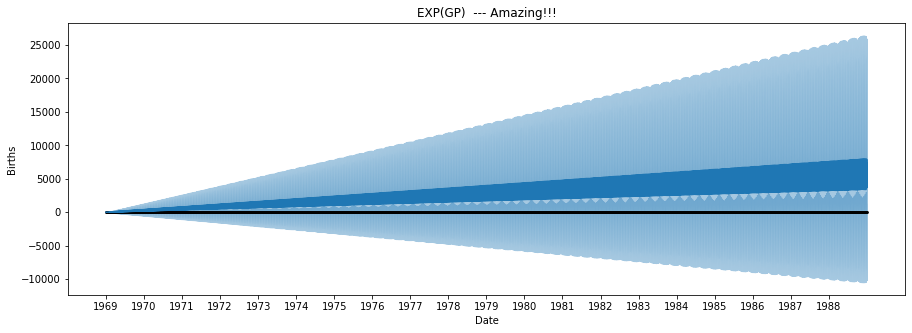

Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch 10 - Loss:  98976568493.8483
tf.Tensor(
[[[-2.95800133 -0.62689912]
  [-6.30083069 -4.67307436]
  [-7.49074103 -6.56708044]
  ...
  [-7.31157748 -6.40824383]
  [-5.87739785 -4.72896879]
  [-1.42014447  0.09812844]]

 [[-2.70493578 -0.62689912]
  [-5.51288038 -4.67307436]
  [-6.4724086  -6.56708044]
  ...
  [-6.31359925 -6.40824383]
  [-5.10586951 -4.72896879]
  [-1.32398062  0.09812844]]

 [[-2.49219033 -0.62689912]
  [-4.85047161 -4.67307436]
  [-5.61632373 -6.56708044]
  ...
  [-5.47462561 -6.40824383]
  [-4.45726624 -4.72896879]
  [-1.24313824  0.09812844]]

 ...

 [[ 0.0551071   2.62320862]
  [ 3.08084816  6.12955771]
  [ 4.63396757  7.43006091]
  ...
  [ 4.57078513  7.31179689]
  [ 3.30875395  5.87735333]
  [-0.27517592  1.42009492]]

 [[ 0.26785254  2.62320862]
  [ 3.74325693  6.12955771]
  [ 5.49005244  7.43006091]
  ...
  [ 5.40975877  7.31179689]
  [ 3.95735722  5.87735333]
  [-0.19433354  1.42009492]]

 [[ 0.52091809  2.6232

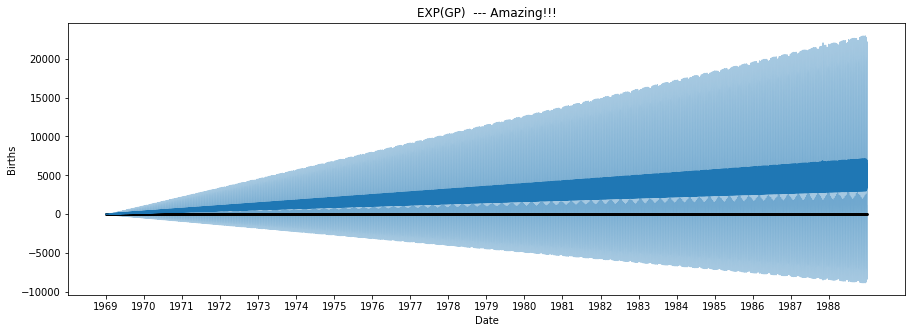

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9422892409555488
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0619056650000602
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9422893710802741
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.06190543260891
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(2000, 1)",float64,[[1.09741491e+00...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(2000, 1)",float64,[[1.09677469e+00...
SVGP.q_mu,Parameter,Identity,,False,"(2000, 2)",float64,"[[-1.26131493, 1.03321637..."
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(2, 2000, 2000)",float64,"[[[2.17552194e-01, 0.00000000e+00, 0.00000000e+00..."


In [27]:
data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 10
log_freq = 5

for epoch in range(1, epochs + 1):
    print('Epoch ', epoch)
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(x)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(x, y, Ymean, Ystd, pos, labels)

model